# Process dataset

In [1]:
import datasets
import os
import json

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/home/ubuntu/nemo_customiser_k8_utils/data'
dataset = datasets.load_dataset(data_path)

In [3]:
# Assuming 'label' is the column you want to stratify by
stratify_column_name = "label"

# Cast the column to ClassLabel
dataset = dataset.class_encode_column(stratify_column_name)

In [4]:
DATASET_PROMPT_FORMAT = """Given the following headline:
### START HEADLINE ###

{headline}

### END HEADLINE ###

What event type best classifies it? Choose from the following list:

-analyst rating
-price targets
-earnings
-labour related
-mergers and acquisitions
-dividends
-regulatory
-stock price movement
-credit ratings
-products-services
-product approval
-guidance
-other

Provide only the event type putting it inside double square brackets and in a new line like:
[[label]]

### START EVENT OUTPUT ###

"""

In [5]:
train_ratio = 0.8
val_ratio = 0.1
seed = 42
test_ratio = 1 - train_ratio - val_ratio
save_splits = {}
dataset = dataset.get('train')
# Get the class labels
class_labels = dataset.features['label']
split_dataset = dataset.train_test_split(test_size=val_ratio + test_ratio, seed=seed, stratify_by_column='label')
split_dataset2 = split_dataset['test'].train_test_split(
    test_size=test_ratio / (val_ratio + test_ratio), seed=seed,stratify_by_column='label')
save_splits['training'] = split_dataset['train']
save_splits['validation'] = split_dataset2['train']
save_splits['test'] = split_dataset2['test']

print("len training: ", len(save_splits['training']))
print("len validation: ", len(save_splits['validation']))
print("len test: ", len(save_splits['test']))

len training:  122808
len validation:  15351
len test:  15352


In [6]:
dataset_root = "data"
os.makedirs(dataset_root, exist_ok=True)

for split_name, dataset in save_splits.items():
    output_file = os.path.join(dataset_root, f"{split_name}.jsonl")
    print(f"Processing {split_name} to {output_file}")
    with open(output_file,"w", encoding="utf-8") as f:
        for example in dataset:
            if DATASET_PROMPT_FORMAT != "":
                _input = DATASET_PROMPT_FORMAT.format(headline=example["headline"])
                _output = class_labels.int2str(example["label"])
            f.write(json.dumps({"prompt": _input, "completion": _output}) + "\n")

    print(f"{split_name} split saved to {output_file}")

Processing training to data/training.jsonl
training split saved to data/training.jsonl
Processing validation to data/validation.jsonl
validation split saved to data/validation.jsonl
Processing test to data/test.jsonl
test split saved to data/test.jsonl


<Figure size 2160x1080 with 0 Axes>

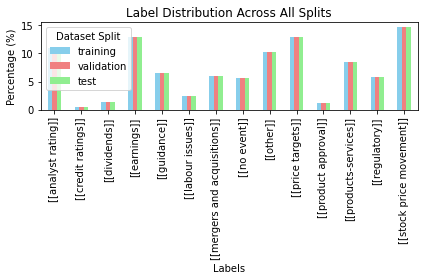

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for all splits
distribution_data = {}
for split, data in save_splits.items():
    df = data.to_pandas()
    df['label'] = df['label'].apply(lambda x: class_labels.int2str(x))
    df_distribution = (df.groupby('label').size()/df.shape[0])*100
    distribution_data[split] = df_distribution

# Convert to DataFrame for easier plotting
combined_df = pd.DataFrame(distribution_data).fillna(0)

# Create the plot
plt.figure(figsize=(30, 15))
combined_df.plot(kind='bar', 
                 title='Label Distribution Across All Splits',
                 xlabel='Labels', 
                 ylabel='Percentage (%)',
                 rot=90,
                 color=['skyblue', 'lightcoral', 'lightgreen'])

plt.legend(title='Dataset Split')
plt.tight_layout()
plt.show()

# Add the datasets to NeMo Microservices

In [8]:
import os
import json
import random
import requests
from openai import OpenAI
from nemo_microservices import NeMoMicroservices

In [9]:
from config import *

# Initialize NeMo Microservices SDK client
nemo_client = NeMoMicroservices(
    base_url=NEMO_URL,
    inference_base_url=NIM_URL,
)

In [10]:
nemo_client.projects.list()

SyncDefaultPagination[Project](object='list', data=[], sort='created_at', pagination=DefaultPaginationPagination(current_page_size=0, page=1, page_size=10, total_pages=0, total_results=0))

In [11]:
print(f"Data Store endpoint: {NDS_URL}")
print(f"Entity Store, Customizer, Evaluator endpoint: {NEMO_URL}")
print(f"NIM endpoint: {NIM_URL}")
print(f"Namespace: {NMS_NAMESPACE}")
print(f"Base Model for Customization: {BASE_MODEL}@{BASE_MODEL_VERSION}")

Data Store endpoint: http://data-store.test
Entity Store, Customizer, Evaluator endpoint: http://nemo.test
NIM endpoint: http://nim.test
Namespace: lora-tutorial-ns
Base Model for Customization: meta/llama-3.1-8b-instruct@v1.0.0+A100


In [12]:
# Path where data preparation notebook saved finetuning and evaluation data
DATA_ROOT = os.path.join(os.getcwd(), "data")
# CUSTOMIZATION_DATA_ROOT = os.path.join(DATA_ROOT, "customization")
# VALIDATION_DATA_ROOT = os.path.join(DATA_ROOT, "validation")
# EVALUATION_DATA_ROOT = os.path.join(DATA_ROOT, "evaluation")

# Sanity checks
train_fp = f"{DATA_ROOT}/training.jsonl"
assert os.path.exists(train_fp), f"The training data at '{train_fp}' does not exist. Please ensure that the data was prepared successfully."

val_fp = f"{DATA_ROOT}/validation.jsonl"
assert os.path.exists(val_fp), f"The validation data at '{val_fp}' does not exist. Please ensure that the data was prepared successfully."

test_fp = f"{DATA_ROOT}/test.jsonl"
assert os.path.exists(test_fp), f"The test data at '{test_fp}' does not exist. Please ensure that the data was prepared successfully."

In [13]:
def create_namespaces(nemo_client, ds_host, namespace):
    # Create namespace in Entity Store
    try:
        namespace_obj = nemo_client.namespaces.create(id=namespace)
        print(f"Created namespace in Entity Store: {namespace_obj.id}")
    except Exception as e:
        # Handle if namespace already exists
        if "409" in str(e) or "422" in str(e):
            print(f"Namespace {namespace} already exists in Entity Store")
        else:
            raise e

    # Create namespace in Data Store (still using requests as SDK doesn't cover Data Store)
    nds_url = f"{ds_host}/v1/datastore/namespaces"
    resp = requests.post(nds_url, data={"namespace": namespace})
    assert resp.status_code in (200, 201, 409, 422), \
        f"Unexpected response from Data Store during namespace creation: {resp.status_code}"
    print(f"Data Store namespace creation response: {resp}")

In [14]:
create_namespaces(nemo_client=nemo_client, ds_host=NDS_URL, namespace=NMS_NAMESPACE)

Created namespace in Entity Store: lora-tutorial-ns
Data Store namespace creation response: <Response [201]>


In [15]:
# Verify Namespace in Data Store (using requests as SDK doesn't cover Data Store)
response = requests.get(f"{NDS_URL}/v1/datastore/namespaces/{NMS_NAMESPACE}")
print(f"Data Store - Status Code: {response.status_code}\nResponse JSON: {response.json()}")

# Verify Namespace in Entity Store
namespace_obj = nemo_client.namespaces.retrieve(namespace_id=NMS_NAMESPACE)
print(f"\nEntity Store - Namespace: {namespace_obj.id}")
print(f"Created at: {namespace_obj.created_at}")
print(f"Description: {namespace_obj.description}")
print(f"Project: {namespace_obj.project}")

Data Store - Status Code: 201
Response JSON: {'namespace': 'lora-tutorial-ns', 'created_at': '2025-08-29T19:24:53Z', 'updated_at': '2025-08-29T19:24:53Z'}

Entity Store - Namespace: lora-tutorial-ns
Created at: 2025-08-29 19:24:53.597238
Description: None
Project: None


In [16]:
repo_id = f"{NMS_NAMESPACE}/{DATASET_NAME}"

In [17]:
from huggingface_hub import HfApi

hf_api = HfApi(endpoint=f"{NDS_URL}/v1/hf", token="")

# Create repo
hf_api.create_repo(
    repo_id=repo_id,
    repo_type='dataset',
)

RepoUrl('datasets/lora-tutorial-ns/news-lora-dataset', endpoint='http://data-store.test/v1/hf', repo_type='dataset', repo_id='lora-tutorial-ns/news-lora-dataset')

In [18]:
hf_api.upload_file(path_or_fileobj=train_fp,
    path_in_repo="training/train.jsonl",
    repo_id=repo_id,
    repo_type='dataset',
)

hf_api.upload_file(path_or_fileobj=val_fp,
    path_in_repo="validation/val.jsonl",
    repo_id=repo_id,
    repo_type='dataset',
)

hf_api.upload_file(path_or_fileobj=test_fp,
    path_in_repo="testing/test.jsonl",
    repo_id=repo_id,
    repo_type='dataset',
)

training.jsonl: 100%|██████████| 78.4M/78.4M [00:00<00:00, 313MB/s]
validation.jsonl: 100%|██████████| 9.79M/9.79M [00:00<00:00, 285MB/s]
test.jsonl: 100%|██████████| 9.79M/9.79M [00:00<00:00, 288MB/s]


CommitInfo(commit_url='', commit_message='Upload testing/test.jsonl with huggingface_hub', commit_description='', oid='899dea8326661e23227ce2da9f7193a4b17119a4', pr_url=None, repo_url=RepoUrl('', endpoint='https://huggingface.co', repo_type='model', repo_id=''), pr_revision=None, pr_num=None)

In [19]:
 # Create dataset
dataset = nemo_client.datasets.create(
    name=DATASET_NAME,
    namespace=NMS_NAMESPACE,
    description="News Dataset for FSI Blueprint",
    files_url=f"hf://datasets/{NMS_NAMESPACE}/{DATASET_NAME}",
    project="tool_calling",
    
)
print(f"Created dataset: {dataset.namespace}/{dataset.name}")
dataset

Created dataset: lora-tutorial-ns/news-lora-dataset


Dataset(files_url='hf://datasets/lora-tutorial-ns/news-lora-dataset', id='dataset-TZBiR4EURjwxjajuSPKy8F', created_at=datetime.datetime(2025, 8, 29, 19, 24, 55, 554999), custom_fields={}, description='News Dataset for FSI Blueprint', format=None, hf_endpoint=None, limit=None, name='news-lora-dataset', namespace='lora-tutorial-ns', project='tool_calling', split=None, updated_at=datetime.datetime(2025, 8, 29, 19, 24, 55, 555002))

In [20]:
# Sanity check to validate dataset
dataset_obj = nemo_client.datasets.retrieve(namespace=NMS_NAMESPACE, dataset_name=DATASET_NAME)

print("Files URL:", dataset_obj.files_url)
assert dataset_obj.files_url == f"hf://datasets/{repo_id}"

Files URL: hf://datasets/lora-tutorial-ns/news-lora-dataset


# Optional - Create subsets of train with smaller sizes

In [21]:
import os, json

SUBSET_SIZES = [5_000, 10_000, 20_000, 50_000, 100_000, "all"]
SEED = 42
OUT_DIR = DATA_ROOT  # assumes defined earlier

def _write_jsonl(ds, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        for ex in ds:
            prompt = DATASET_PROMPT_FORMAT.format(headline=ex["headline"]) if DATASET_PROMPT_FORMAT else ex["headline"]
            completion = class_labels.int2str(ex["label"])
            f.write(json.dumps({"prompt": prompt, "completion": completion}) + "\n")

train_full = save_splits["training"]
print("Full train size:", len(train_full))

made = []
for size in SUBSET_SIZES:
    if size == "all" or (isinstance(size, int) and size >= len(train_full)):
        sub = train_full
        tag = "all"
    else:
        sub = train_full.train_test_split(
            train_size=size, seed=SEED, stratify_by_column="label"
        )["train"]
        tag = f"{size//1000}k"
    out_fp = os.path.join(OUT_DIR, f"training_{tag}.jsonl")
    _write_jsonl(sub, out_fp)
    print(f"Saved subset {tag}: {len(sub)} -> {out_fp}")
    made.append((tag, out_fp))

# Optional upload to same HF dataset repo if available
try:
    _ = repo_id  # defined earlier
    for tag, fp in made:
        hf_api.upload_file(
            path_or_fileobj=fp,
            path_in_repo=f"training/train_{tag}.jsonl",
            repo_id=repo_id,
            repo_type="dataset",
        )
        print(f"Uploaded {tag} to training/train_{tag}.jsonl")
except NameError:
    print("Skipping upload (hf_api/repo_id not defined).")

Full train size: 122808
Saved subset 5k: 5000 -> /home/ubuntu/nemo_customiser_k8_utils/nemoms_pythonsdk_lora/data/training_5k.jsonl
Saved subset 10k: 10000 -> /home/ubuntu/nemo_customiser_k8_utils/nemoms_pythonsdk_lora/data/training_10k.jsonl
Saved subset 20k: 20000 -> /home/ubuntu/nemo_customiser_k8_utils/nemoms_pythonsdk_lora/data/training_20k.jsonl
Saved subset 50k: 50000 -> /home/ubuntu/nemo_customiser_k8_utils/nemoms_pythonsdk_lora/data/training_50k.jsonl
Saved subset 100k: 100000 -> /home/ubuntu/nemo_customiser_k8_utils/nemoms_pythonsdk_lora/data/training_100k.jsonl
Saved subset all: 122808 -> /home/ubuntu/nemo_customiser_k8_utils/nemoms_pythonsdk_lora/data/training_all.jsonl


training_5k.jsonl: 100%|██████████| 3.19M/3.19M [00:00<00:00, 114MB/s]


Uploaded 5k to training/train_5k.jsonl


training_10k.jsonl: 100%|██████████| 6.38M/6.38M [00:00<00:00, 249MB/s]


Uploaded 10k to training/train_10k.jsonl


training_20k.jsonl: 100%|██████████| 12.8M/12.8M [00:00<00:00, 281MB/s]


Uploaded 20k to training/train_20k.jsonl


training_50k.jsonl: 100%|██████████| 31.9M/31.9M [00:00<00:00, 324MB/s]


Uploaded 50k to training/train_50k.jsonl


training_100k.jsonl: 100%|██████████| 63.8M/63.8M [00:00<00:00, 301MB/s]


Uploaded 100k to training/train_100k.jsonl
Uploaded all to training/train_all.jsonl
